# 1. Importing dependencies

In [1]:
!pip install ipython-autotime -q
%load_ext autotime

import sys, os
import zipfile
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import optuna
import sklearn
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Layer, Flatten, Input, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, AdamW, SGD, RMSprop
from tensorflow.keras.applications import VGG19, EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3, EfficientNetV2S, EfficientNetV2M, EfficientNetV2L
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnetv2_preprocess_input
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score

2024-07-09 14:38:04.420783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 14:38:04.420898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 14:38:04.550561: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


time: 13.6 s (started: 2024-07-09 14:38:01 +00:00)


In [2]:
print("-"*50)
print(f"Python Version\t:")
!python --version
print("-"*50)
print(f"Numpy Version\t\t: {np.__version__}")
print(f"Pandas Version\t\t: {pd.__version__}")
print(f"Tensorflow Version\t: {tf.__version__}")
print(f"Matplotlib Version\t: {matplotlib.__version__}")
print(f"Seaborn Version\t\t: {sns.__version__}")
print(f"Scikit-learn Version\t: {sklearn.__version__}")
print(f"Optuna Version\t\t: {optuna.__version__}")
print(f"GPU Accelerator\t\t: {tf.config.list_physical_devices('GPU')}")
print("-"*50)

--------------------------------------------------
Python Version	:


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Python 3.10.13
--------------------------------------------------
Numpy Version		: 1.26.4
Pandas Version		: 2.2.2
Tensorflow Version	: 2.15.0
Matplotlib Version	: 3.7.5
Seaborn Version		: 0.12.2
Scikit-learn Version	: 1.2.2
Optuna Version		: 3.6.1
GPU Accelerator		: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
--------------------------------------------------
time: 1.32 s (started: 2024-07-09 14:38:15 +00:00)


In [3]:
!nvidia-smi

Tue Jul  9 14:38:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. Utils

## 2.1. Show Images

In [4]:
def show_images_from_generator(generator, num_images=5):
    sample_images, sample_labels = next(generator)

    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    axes = axes.flatten()
    for img, label, ax in zip(sample_images[:num_images], sample_labels[:num_images], axes):
        ax.imshow(img)
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

time: 1.14 ms (started: 2024-07-09 14:38:17 +00:00)


## 2.2. EDA

In [5]:
def show_number_of_sample_train_test(train_set, valid_set, test_set):
    class_names = list(train_set.class_indices.keys())

    # Calculate class counts for train, valid, and test sets
    train_class_count = np.unique(train_set.classes, return_counts=True)
    valid_class_count = np.unique(valid_set.classes, return_counts=True)
    test_class_count = np.unique(test_set.classes, return_counts=True)

    # Sum train and validation counts
    total_train_valid_counts = train_class_count[1] + valid_class_count[1]

    plt.figure(figsize=(10, 5))

    # Combined Train + Validation Set
    plt.subplot(1, 2, 1)
    sns.barplot(x=class_names, y=total_train_valid_counts, palette=['mediumturquoise', 'orangered'])
    plt.title('Total Train + Validation Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(total_train_valid_counts):
        plt.text(index, value, str(value), ha='center', va='bottom')

    # Test Set
    plt.subplot(1, 2, 2)
    sns.barplot(x=class_names, y=test_class_count[1], palette=['mediumturquoise', 'orangered'])
    plt.title('Test Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(test_class_count[1]):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


time: 10.9 ms (started: 2024-07-09 14:38:17 +00:00)


In [6]:
def show_number_of_sample(train_set, valid_set, test_set):
    class_names = list(train_set.class_indices.keys())

    train_class_count = np.unique(train_set.classes, return_counts=True)
    valid_class_count = np.unique(valid_set.classes, return_counts=True)
    test_class_count = np.unique(test_set.classes, return_counts=True)

    plt.figure(figsize=(15, 5))

    # Train Set
    plt.subplot(1, 3, 1)
    sns.barplot(x=class_names, y=train_class_count[1], palette=['mediumturquoise', 'orangered'])
    plt.title('Train Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(train_class_count[1]):
        plt.text(index, value, str(value), ha='center', va='bottom')

    # Validation Set
    plt.subplot(1, 3, 2)
    sns.barplot(x=class_names, y=valid_class_count[1], palette=['mediumturquoise', 'orangered'])
    plt.title('Validation Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(valid_class_count[1]):
        plt.text(index, value, str(value), ha='center', va='bottom')

    # Test Set
    plt.subplot(1, 3, 3)
    sns.barplot(x=class_names, y=test_class_count[1], palette=['mediumturquoise', 'orangered'])
    plt.title('Test Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(test_class_count[1]):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

time: 3.76 ms (started: 2024-07-09 14:38:17 +00:00)


In [7]:
def show_number_of_data_separation_train_test(train_set, valid_set, test_set):

    # Calculate the total number of samples in each set
    total_train_samples = len(train_set.labels)
    total_valid_samples = len(valid_set.labels)
    total_test_samples = len(test_set.labels)

    # Combine train and validation samples
    total_train_valid_samples = total_train_samples + total_valid_samples
    total_samples = total_train_valid_samples + total_test_samples

    # Calculate the percentages
    train_valid_percentage = (total_train_valid_samples / total_samples) * 100
    test_percentage = (total_test_samples / total_samples) * 100

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace': 0.4})

    # Pie chart
    labels = ['Train + Validation', 'Test']
    sizes = [train_valid_percentage, test_percentage]
    colors = ['gold', 'lightcoral']
    explode = (0.1, 0)  # explode 1st slice
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax1.axis('equal')
    ax1.set_title('\nPercentage of Data Samples\n')

    # Bar chart
    categories = ['Train + Validation', 'Test']
    counts = [total_train_valid_samples, total_test_samples]
    bars = ax2.bar(categories, counts, color=colors)
    ax2.set_ylabel('Number of Samples')
    ax2.set_title('\nNumber of Samples in Each Set\n')

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, height, count, ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


time: 5.2 ms (started: 2024-07-09 14:38:17 +00:00)


In [8]:
def show_number_of_data_separation(train_set, valid_set, test_set):

    total_train_samples = len(train_set.labels)
    total_valid_samples = len(valid_set.labels)
    total_test_samples = len(test_set.labels)

    total_samples = total_train_samples + total_valid_samples + total_test_samples

    train_percentage = (total_train_samples / total_samples) * 100
    valid_percentage = (total_valid_samples / total_samples) * 100
    test_percentage = (total_test_samples / total_samples) * 100

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace': 0.4})

    labels = ['Train', 'Validation', 'Test']
    sizes = [train_percentage, valid_percentage, test_percentage]
    colors = ['gold', 'yellowgreen', 'lightcoral']
    explode = (0.1, 0, 0)  # explode 1st slice
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax1.axis('equal')
    ax1.set_title('\nPersentase Jumlah Data\n')

    categories = ['Train', 'Validation', 'Test']
    counts = [total_train_samples, total_valid_samples, total_test_samples]
    bars = ax2.bar(categories, counts, color=colors)
    ax2.set_ylabel('Jumlah Data')
    ax2.set_title('\nJumlah Data dalam Setiap Kategori\n')

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, height, count, ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

time: 4.75 ms (started: 2024-07-09 14:38:17 +00:00)


In [9]:
def count_datasets(dir_path):
    img_count_author_asli = 0
    img_count_author_palsu = 0
    img_count_external_asli = 0
    img_count_external_palsu = 0

    for dirpath, dirnames, filenames in os.walk(dir_path):
        if 'Asli' in dirpath:
            for filename in filenames:
                if filename.startswith("IMG_"):
                    img_count_author_asli += 1
                else:
                    img_count_external_asli += 1
        elif 'Palsu' in dirpath:
            for filename in filenames:
                if filename.startswith("IMG_"):
                    img_count_author_palsu += 1
                else:
                    img_count_external_palsu += 1

    return img_count_author_asli, img_count_author_palsu, img_count_external_asli, img_count_external_palsu

def show_count_datasets(dir_path):
    author_asli, author_palsu, external_asli, external_palsu = count_datasets(dir_path)

    labels = ['Hasil Pemotretan Penulis', 'Sumber Eksternal']
    counts_asli = [author_asli, external_asli]
    counts_palsu = [author_palsu, external_palsu]

    x = range(len(labels))
    bar_width = 0.35

    plt.bar(x, counts_asli, width=bar_width, label='Asli', color='mediumturquoise', align='center')
    plt.bar([i + bar_width for i in x], counts_palsu, width=bar_width, label='Palsu', color='orangered', align='center')

    for i, v in enumerate(counts_asli):
        plt.text(i - 0.1, v + 5, str(v), color='black')

    for i, v in enumerate(counts_palsu):
        plt.text(i + bar_width - 0.1, v + 5, str(v), color='black')

    plt.xlabel('Sumber Dataset')
    plt.ylabel('Jumlah Gambar')
    plt.title('Perbandingan Jumlah Dataset')
    plt.xticks([i + bar_width / 2 for i in x], labels)
    plt.legend()
    plt.show()

time: 4.36 ms (started: 2024-07-09 14:38:17 +00:00)


## 2.3. Callbacks Preparation

In [10]:
def callbacks_list(monitor='val_loss', model_save_pathname='best_model.keras', early_stopping_patience=5, learning_rate_patience=3, learning_rate_scheme=0):
    '''TensorBoard'''
    # log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tb_callbacks = TensorBoard(log_dir=log_folder)
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    '''EarlyStoping'''
    cnn_es_callback = EarlyStopping(monitor=monitor, min_delta=0, patience=early_stopping_patience, verbose=1)

    '''ModelCheckPoint'''
    cnn_mpt_callback = ModelCheckpoint(filepath=model_save_pathname, monitor=monitor, mode='auto', save_best_only=True, verbose=1)

    '''LearningRateScheduler'''
    def learning_rate_schedule(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return float(lr * tf.math.exp(-0.1))

    lr_scheduler = LearningRateScheduler(learning_rate_schedule, verbose=1)

    '''ReduceLROnPlateau'''
    lr_reduction = ReduceLROnPlateau(monitor=monitor, factor=0.5, patience=learning_rate_patience, min_lr=1e-8, verbose=1)

    '''ReturnCallbacks'''
    if learning_rate_scheme == 0:
        callbacks = [cnn_es_callback, cnn_mpt_callback]
    elif learning_rate_scheme == 1:
        callbacks = [cnn_es_callback, cnn_mpt_callback, lr_scheduler]
    elif learning_rate_scheme == 2:
        callbacks = [cnn_es_callback, cnn_mpt_callback, lr_reduction]
    else:
        callbacks = []
        print('The value for learning_rate_scheme is only 0, 1, or 2.')

    return callbacks

time: 2.28 ms (started: 2024-07-09 14:38:17 +00:00)


## 2.4. Evaluation Preparation

In [11]:
class History():
    def __init__(self, history, model_name='MODEL'):
        self.history = history
        self.model_name = model_name

    def plot_accuracy_and_lost(self):
        history = self.history

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(history.history['accuracy'], linestyle='--', label='accuracy')
        axs[0].plot(history.history['val_accuracy'], linestyle='-.', label='val_accuracy', )
        axs[0].set_title(f"\n{self.model_name} Accuracy\n")
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Accuracy')
        axs[0].legend()

        axs[1].plot(history.history['loss'], linestyle='--', label='loss')
        axs[1].plot(history.history['val_loss'], linestyle='-.', label='val_loss', )
        axs[1].set_title(f"\n{self.model_name} Loss\n")
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Loss')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

    def plot_learningrate(self):
        history = self.history

        plt.plot(history.history['learning_rate'], color='orangered', linestyle='--', marker='o', label='learning_rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title(f'\n{self.model_name} Learning Rate\n')
        plt.legend()
        plt.show()

time: 4.39 ms (started: 2024-07-09 14:38:17 +00:00)


In [12]:
class ModelEvaluation():
    def __init__(self, model, test_set, model_name='MODEL'):
        self.model = model
        self.test_set = test_set
        self.y_true = test_set.classes
        self.y_pred = model.predict(test_set)
        self.model_name = model_name

    def evaluate(self):
        return self.model.evaluate(self.test_set)
    
    def predict_test(self):
        return self.y_true, self.y_pred

    def confusion_matrix(self):
        y_true = self.y_true
        y_pred = self.y_pred
        y_pred_classes = np.argmax(y_pred, axis=1)
        conf_matrix = confusion_matrix(y_true, y_pred_classes)
        return conf_matrix

    def classification_report(self):
        y_true = self.y_true
        y_pred = self.y_pred
        y_pred_classes = np.argmax(y_pred, axis=1)
        target_names = list(self.test_set.class_indices.keys())
        print(f"{self.model_name} Classification Report")
        print(classification_report(y_true, y_pred_classes, target_names=target_names))

    def roc_auc(self):
        y_true = self.y_true
        y_pred = self.y_pred
        roc_auc = {}
        target_names = list(self.test_set.class_indices.keys())
        for i in range(len(target_names)):
            roc_auc[target_names[i]] = roc_auc_score((y_true == i).astype(int), y_pred[:, i])
        return roc_auc

    def plot_confusion_matrix(self):
        conf_matrix = self.confusion_matrix()
        labels = list(self.test_set.class_indices.keys())
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f'{self.model_name} Confusion Matrix')
        plt.show()

    def plot_roc_auc(self):
        y_true = self.y_true
        y_pred = self.y_pred
        n_classes = len(np.unique(y_true))

        fpr, tpr, _ = roc_curve(y_true == 0, y_pred[:, 0])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        lw = 2
        plt.plot(fpr, tpr, lw=lw, label='ROC class "{}" (AUC area = {:.2f})'.format(list(self.test_set.class_indices.keys())[0], roc_auc))
        plt.fill_between(fpr, tpr, color='orange', alpha=0.3)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{self.model_name} ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

time: 4.69 ms (started: 2024-07-09 14:38:17 +00:00)


## 2.5. Train and Calculate Model Execution Time

In [13]:
def train_model_with_callbacks(model, training_set, validation_set, epochs=1, batch_size=32, verbose='auto', callbacks=[]):
    print("="*50)
    print("\t\tSTART TRAINING")
    print("="*50+"\n")

    try:
        start_time = time.time()

        history = model.fit(
            training_set,
            validation_data=validation_set,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            callbacks=callbacks,
        )

        end_time = time.time()
    except tf.errors.ResourceExhaustedError as e:
        print()
        print("-"*50)
        print("Kesalahan: Resource Exhausted (GPU Kehabisan Memori)!!!")
        # print(e)
        print("-"*50)
    else:
        duration_seconds = end_time - start_time
        duration_minutes = duration_seconds // 60
        duration_seconds_modulo =  duration_seconds % 60
        duration_seconds_per_epoch = duration_seconds / len(history.history['learning_rate'])

        print()
        print("="*50)
        print("\t\tTRAINING COMPLETE")
        print("="*50)
        print(f"Total training Time:\n{int(duration_minutes)} minutes {int(duration_seconds_modulo)} seconds ({duration_seconds} total seconds).")
        print(f"Training Time Per Epoch:\n{duration_seconds_per_epoch:.2f}s/epoch")
        print(f"Total Epoch:\n{len(history.history['learning_rate'])}")
        print("="*50)

        return history

    print()
    print("="*50)
    print("\t\tTRAINING COMPLETE")
    print("="*50)

time: 4.52 ms (started: 2024-07-09 14:38:17 +00:00)


# 3. Config

In [14]:
class Config:
    IMAGE_SIZE = 256 # best 448 # option: 256, 448, 512
    BATCH_SIZE = 64 # best 32 # option: 32, 64
    SEED = 42 # default 42
    LABEL_MODE = 'categorical'
    VAL_SPLIT = 0.3 # best 0.3
    COLOR_MODE = 'rgb'
    CHANNEL = 3
    MONITOR = 'val_loss'
    LR = 1e-05 # best 1e-05
    LOSSES = CategoricalCrossentropy()
    METRICS = ['accuracy']
    ES_PATIENCE = 10 # mostly 15
    LR_PATIENCE = 5 # mostly 5
    LR_SCHEME = 2 # mostly 2
    EPOCH = 1000
    OUTPUT_LAYER = 2
    OUTPUT_ACTIVATION = 'softmax'

time: 6.96 ms (started: 2024-07-09 14:38:17 +00:00)


In [15]:
np.random.seed(Config.SEED)
tf.random.set_seed(Config.SEED)
# tf.config.experimental.enable_op_determinism()

time: 5.81 ms (started: 2024-07-09 14:38:17 +00:00)


# 4. Load Dataset

In [16]:
dir_path = '/kaggle/input/uang-rupiah-asli-palsu-v5-0'
train_set_dir = dir_path + '/train'
test_set_dir = dir_path + '/test'

for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"Terdapat {len(dirnames)} direktori and {len(filenames)} file gambar di '{dirpath}'.")

Terdapat 2 direktori and 0 file gambar di '/kaggle/input/uang-rupiah-asli-palsu-v5-0'.
Terdapat 2 direktori and 0 file gambar di '/kaggle/input/uang-rupiah-asli-palsu-v5-0/test'.
Terdapat 0 direktori and 165 file gambar di '/kaggle/input/uang-rupiah-asli-palsu-v5-0/test/Asli'.
Terdapat 0 direktori and 53 file gambar di '/kaggle/input/uang-rupiah-asli-palsu-v5-0/test/Palsu'.
Terdapat 2 direktori and 0 file gambar di '/kaggle/input/uang-rupiah-asli-palsu-v5-0/train'.
Terdapat 0 direktori and 708 file gambar di '/kaggle/input/uang-rupiah-asli-palsu-v5-0/train/Asli'.
Terdapat 0 direktori and 162 file gambar di '/kaggle/input/uang-rupiah-asli-palsu-v5-0/train/Palsu'.
time: 447 ms (started: 2024-07-09 14:38:17 +00:00)


# 5. Dataset Generator (With Augment) and Visualization

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1/255.,
#     rotation_range=180,
#     width_shift_range=0.01,
#     height_shift_range=0.01,
#     shear_range=0.05,
#     zoom_range=0.1,
#     horizontal_flip=False,
#     vertical_flip=False,
#     fill_mode='nearest',
    validation_split=Config.VAL_SPLIT,
)

valid_datagen = ImageDataGenerator(
    rescale=1/255.,
    validation_split=Config.VAL_SPLIT,
)

test_datagen = ImageDataGenerator(
    rescale=1./255.,
)

time: 833 µs (started: 2024-07-09 14:38:18 +00:00)


In [18]:
train_set = train_datagen.flow_from_directory(
    directory=train_set_dir,
    shuffle=True,
    target_size=(Config.IMAGE_SIZE, Config.IMAGE_SIZE),
    
    batch_size=Config.BATCH_SIZE,
    class_mode=Config.LABEL_MODE,
    color_mode=Config.COLOR_MODE,
    subset='training',
    seed=Config.SEED,
)

valid_set = valid_datagen.flow_from_directory(
    directory=train_set_dir,
    shuffle=True,
    target_size=(Config.IMAGE_SIZE, Config.IMAGE_SIZE),
    batch_size=Config.BATCH_SIZE,
    class_mode=Config.LABEL_MODE,
    subset='validation',
    color_mode=Config.COLOR_MODE,
    seed=Config.SEED,
)

test_set = test_datagen.flow_from_directory(
    directory=test_set_dir,
    shuffle=False,
    target_size=(Config.IMAGE_SIZE, Config.IMAGE_SIZE),
    batch_size=Config.BATCH_SIZE,
    class_mode=Config.LABEL_MODE,
)

Found 610 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 218 images belonging to 2 classes.
time: 53.8 ms (started: 2024-07-09 14:38:18 +00:00)


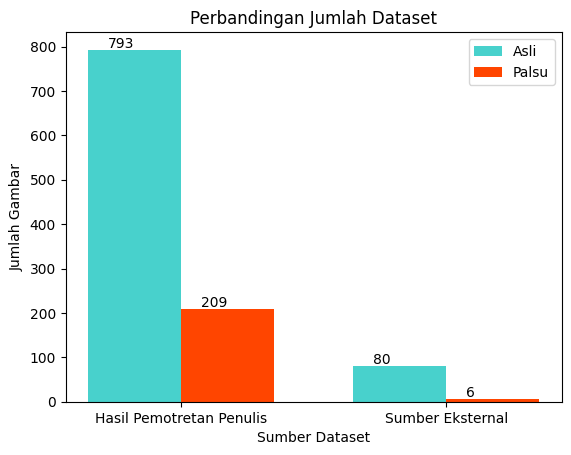

time: 347 ms (started: 2024-07-09 14:38:18 +00:00)


In [19]:
show_count_datasets(dir_path)

/tmp/ipykernel_34/1519368549.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


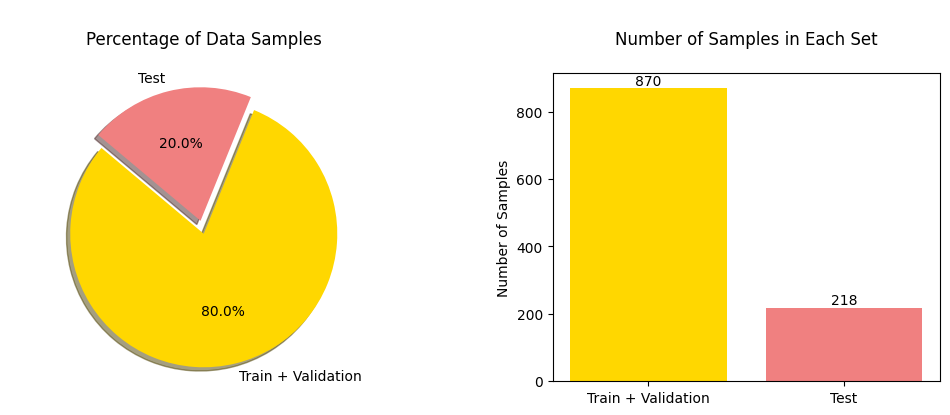

time: 380 ms (started: 2024-07-09 14:38:18 +00:00)


In [20]:
show_number_of_data_separation_train_test(train_set, valid_set, test_set)

In [21]:
# show_number_of_data_separation(train_set, valid_set, test_set)

time: 278 µs (started: 2024-07-09 14:38:19 +00:00)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


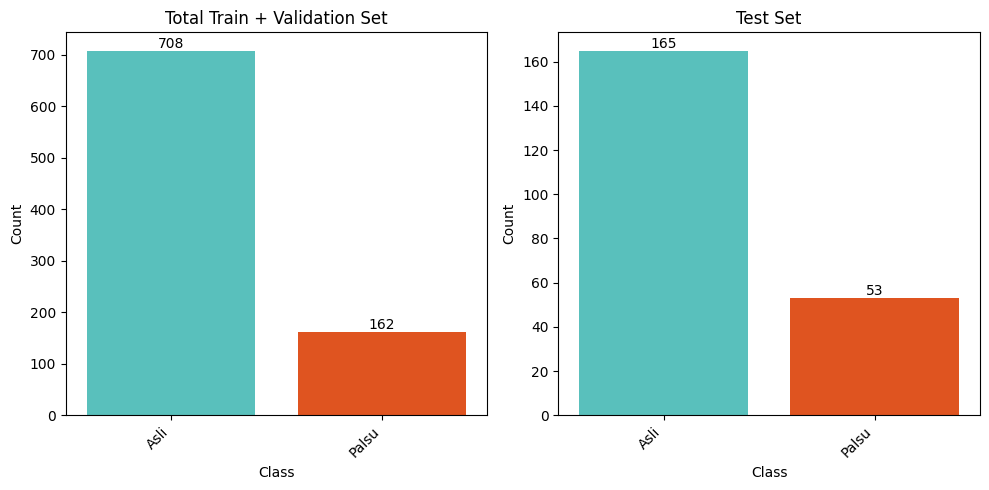

time: 468 ms (started: 2024-07-09 14:38:19 +00:00)


In [22]:
show_number_of_sample_train_test(train_set, valid_set, test_set)

In [23]:
# show_number_of_sample(train_set, valid_set, test_set)

time: 330 µs (started: 2024-07-09 14:38:19 +00:00)


In [24]:
test_set.class_indices

{'Asli': 0, 'Palsu': 1}

time: 6.7 ms (started: 2024-07-09 14:38:19 +00:00)


Train Set:


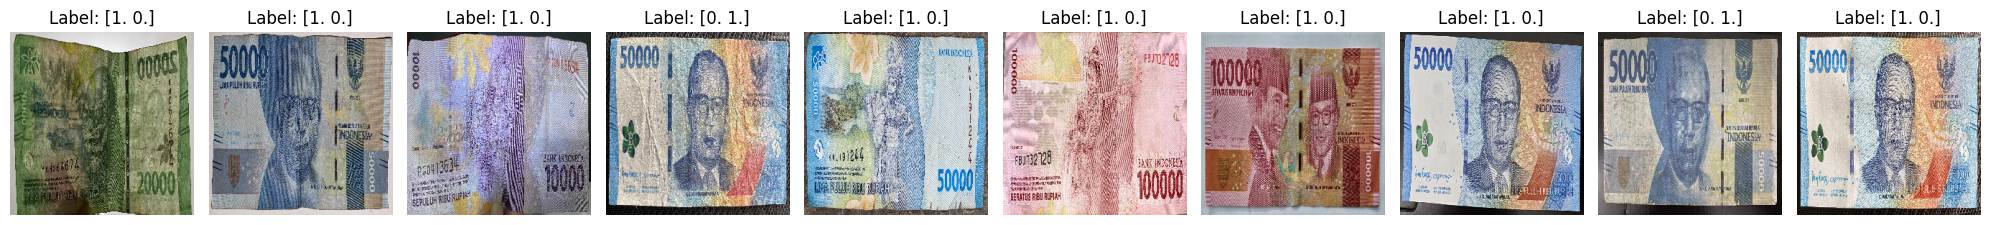

Validation Set:


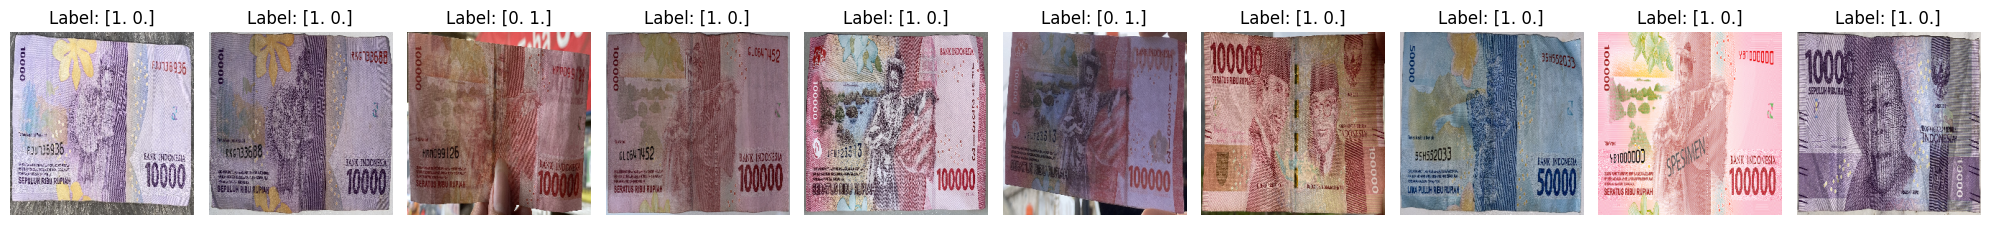

Test Set:


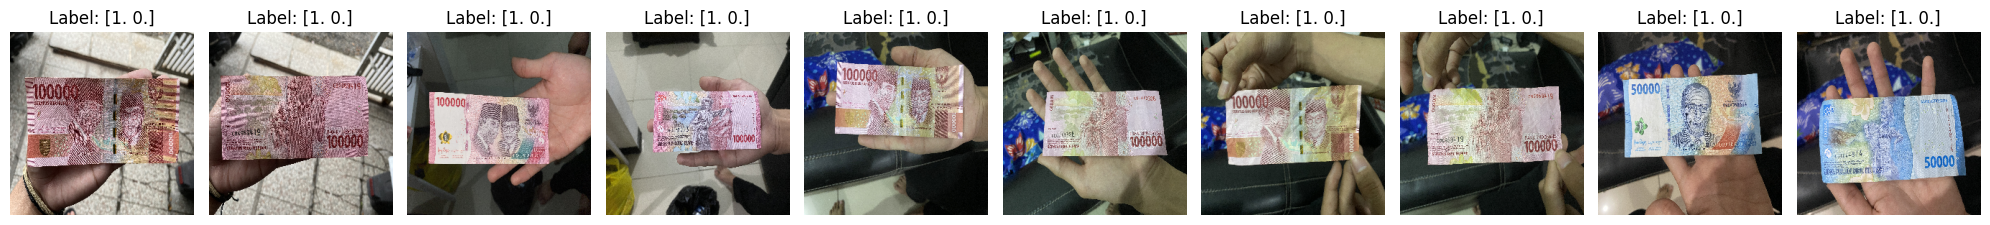

time: 21.8 s (started: 2024-07-09 14:38:19 +00:00)


In [25]:
print("Train Set:")
show_images_from_generator(train_set, num_images=10)

print("Validation Set:")
show_images_from_generator(valid_set, num_images=10)

print("Test Set:")
show_images_from_generator(test_set, num_images=10)

# 6. Building Models

## 6.1. Custom CNN

In [26]:
cnn_model = Sequential(name='custom_cnn_model')

cnn_model.add(Input(shape=(Config.IMAGE_SIZE, Config.IMAGE_SIZE, Config.CHANNEL)))

cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',))

cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',))

cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',))

cnn_model.add(Flatten())

cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Dense(units=Config.OUTPUT_LAYER, activation=Config.OUTPUT_ACTIVATION))

cnn_model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=AdamW(learning_rate=Config.LR),
    metrics=['accuracy'],
)

cnn_model.summary(show_trainable=True)

Model: "custom_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ conv2d (Conv2D)             │ (None, 254, 254, 32)  │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d               │ (None, 127, 127, 32)  │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_1 (Conv2D)           │ (None, 125, 125, 64)  │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_1             │ (None, 62, 62, 64)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_2 (Conv2D)           │ (None, 60, 60, 64)    │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_2             │ (None, 30, 30, 64)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_3 (Conv2D)           │ (None, 28, 28, 128)   │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_3             │ (None, 14, 14, 128)   │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_4 (Conv2D)           │ (None, 12, 12, 128)   │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_4             │ (None, 6, 6, 128)     │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 4608)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 512)           │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 2)             │      1,026 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 2,638,594 (10.07 MB)

 Trainable params: 2,638,594 (10.07 MB)

 Non-trainable params: 0 (0.00 B)

time: 692 ms (started: 2024-07-09 14:38:41 +00:00)


In [27]:
# plot_model(
#     cnn_model, 
#     show_shapes=True, 
#     show_dtype=False, 
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
#     show_trainable=True,
#     to_file='cnn_model.png'
#     )

time: 440 µs (started: 2024-07-09 14:38:42 +00:00)


## 6.2. VGG-19

In [28]:
vgg19_base_model = VGG19(
    include_top = False,
    weights = 'imagenet',
    input_shape = (Config.IMAGE_SIZE, Config.IMAGE_SIZE, Config.CHANNEL),
    pooling='avg',
)

vgg19_base_model.trainable = True

# x = GlobalAveragePooling2D()(efficientnetv2_base_model.output) # pooling = 'avg'
x = Dense(units=512, activation='relu')(vgg19_base_model.output)
# x = Dense(units=512, activation='relu')(x)
x = Dense(units=Config.OUTPUT_LAYER, activation=Config.OUTPUT_ACTIVATION)(x)

vgg19_model = Model(inputs=vgg19_base_model.input, outputs=x, name='vgg19_model')

vgg19_model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=AdamW(learning_rate=Config.LR),
    metrics=['accuracy'],
)

vgg19_model.summary(show_trainable=True)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg19_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 256, 256, 64)  │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 256, 256, 64)  │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 128, 128, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 128, 128, 128) │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 128, 128, 128) │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 64, 64, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 64, 64, 256)   │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv4 (Conv2D)       │ (None, 64, 64, 256)   │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 32, 32, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 32, 32, 512)   │  1,180,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv4 (Conv2D)       │ (None, 32, 32, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 16, 16, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv4 (Conv2D)       │ (None, 16, 16, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 8, 8, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 512)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 512)           │    262,656 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼─────

 Total params: 20,288,066 (77.39 MB)

 Trainable params: 20,288,066 (77.39 MB)

 Non-trainable params: 0 (0.00 B)

time: 950 ms (started: 2024-07-09 14:38:42 +00:00)


In [29]:
# plot_model(
#     vgg19_model, 
#     show_shapes=True, 
#     show_dtype=False, 
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
#     show_trainable=True,
#     to_file='vgg19_model.png'
#     )

time: 429 µs (started: 2024-07-09 14:38:43 +00:00)


## 6.3. EficientNetV2B2

In [30]:
efficientnetv2b2_base_model = EfficientNetV2B2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (Config.IMAGE_SIZE, Config.IMAGE_SIZE, Config.CHANNEL),
    pooling='avg',
)

efficientnetv2b2_base_model.trainable = True

# x = GlobalAveragePooling2D()(efficientnetv2_base_model.output) # pooling = 'avg'
x = Dense(units=512, activation='relu')(efficientnetv2b2_base_model.output)
# x = Dense(units=512, activation='relu')(x)
x = Dense(units=Config.OUTPUT_LAYER, activation=Config.OUTPUT_ACTIVATION)(x)

efficientnetv2b2_model = Model(inputs=efficientnetv2b2_base_model.input, outputs=x, name='efficientnetv2b2_model')

efficientnetv2b2_model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=AdamW(learning_rate=Config.LR),
    metrics=['accuracy'],
)

efficientnetv2b2_model.summary(show_trainable=True)

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetv2b2_model"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2     │ (None, 256,     │         0 │ -              │   -   │
│ (InputLayer)      │ 256, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling         │ (None, 256,     │         0 │ input_layer_2… │   -   │
│ (Rescaling)       │ 256, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ normalization     │ (None, 256,     │         0 │ rescaling[0][… │   -   │
│ (Normalization)   │ 256, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv         │ (None, 128,     │       864 │ normalization… │   Y   │
│ (Conv2D)          │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_bn           │ (None, 128,     │       128 │ stem_conv[0][… │   Y   │
│ (BatchNormalizat… │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_activation   │ (None, 128,     │         0 │ stem_bn[0][0]  │   -   │
│ (Activation)      │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 128,     │     4,608 │ stem_activati… │   Y   │
│ (Conv2D)          │ 128, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 128,     │        64 │ block1a_proje… │   Y   │
│ (BatchNormalizat… │ 128, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 128,     │         0 │ block1a_proje… │   -   │
│ (Activation)      │ 128, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 128,     │     2,304 │ block1a_proje… │   Y   │
│ (Conv2D)          │ 128, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 128,     │        64 │ block1b_proje… │   Y   │
│ (BatchNormalizat… │ 128, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 128,     │         0 │ block1b_proje… │   -   │
│ (Activation)      │ 128, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_drop      │ (None, 128,     │         0 │ block1b_proje… │   -   │
│ (Dropout)         │ 128, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_add (Add) │ (None, 128,     │         0 │ block1b_drop[… │   -   │
│                   │ 128, 16)        │           │ block1a_proje… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_c… │ (None, 64, 64,  │     9,216 │ block1b_add[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_bn │ (None, 64, 64,  │       256 │ block2a_expan… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_a… │ (None, 64, 64,  │         0 │ block2a_expan… │   - 

 Total params: 9,491,808 (36.21 MB)

 Trainable params: 9,409,520 (35.89 MB)

 Non-trainable params: 82,288 (321.44 KB)

time: 3.29 s (started: 2024-07-09 14:38:43 +00:00)


In [31]:
# plot_model(
#     efficientnetv2b2_model, 
#     show_shapes=True, 
#     show_dtype=False, 
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
#     show_trainable=True,
#     to_file='efficientnetv2b2_model.png'
#     )

time: 860 µs (started: 2024-07-09 14:38:46 +00:00)


# 7. Training

## 7.1. Custom CNN

In [32]:
CALLBACKS = callbacks_list(
    monitor=Config.MONITOR,
    model_save_pathname='cnn_best_model.keras',
    early_stopping_patience=Config.ES_PATIENCE,
    learning_rate_patience=Config.LR_PATIENCE,
    learning_rate_scheme=Config.LR_SCHEME
)

cnn_history = train_model_with_callbacks(
    model=cnn_model,
    training_set=train_set,
    validation_set=valid_set,
    epochs=Config.EPOCH,
    batch_size=Config.BATCH_SIZE,
    verbose='auto',
    callbacks=CALLBACKS,
)

		START TRAINING

Epoch 1/1000


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-09 14:39:32.718320: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,256,256]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-09 14:39:32.777980: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 285: 4.39352, expected 3.84026
2

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8047 - loss: 0.6630 

I0000 00:00:1720535985.454072     136 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720535985.479639     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 3/10 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7969 - loss: 0.6612 

2024-07-09 14:39:52.607009: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31: 5.52594, expected 4.85849
2024-07-09 14:39:52.607082: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 5.57544, expected 4.90798
2024-07-09 14:39:52.607093: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 72: 5.54965, expected 4.88219
2024-07-09 14:39:52.607117: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 177: 5.63107, expected 4.96361
2024-07-09 14:39:52.607126: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 178: 5.51769, expected 4.85023
2024-07-09 14:39:52.607135: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 284: 5.67217, expected 5.00472
2024-07-09 14:39:52.607144: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 285: 4.63475, expected 3.96729
2024-07-09 14:39:52.607154: E external/local

 6/10 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7787 - loss: 0.6576

W0000 00:00:1720536000.066287     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7786 - loss: 0.6482

W0000 00:00:1720536009.117214     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-07-09 14:40:17.571716: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129063: 5.35229, expected 4.67255
2024-07-09 14:40:17.571772: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129317: 4.6381, expected 3.95836
2024-07-09 14:40:17.571783: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129442: 5.36458, expected 4.68484
2024-07-09 14:40:17.571793: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129443: 5.7503, expected 5.07056
2024-07-09 14:40:17.571802: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129464: 5.45647, expected 4.77673
2024-07-09 14:40:17.571811: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 129486: 5.67042, expected 4.99069
2024-07-09 14:40:17.571820: E externa


Epoch 1: val_loss improved from inf to 0.58570, saving model to cnn_best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.7791 - loss: 0.6461 - val_accuracy: 0.8154 - val_loss: 0.5857 - learning_rate: 1.0000e-05
Epoch 2/1000


W0000 00:00:1720536018.610323     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.8225 - loss: 0.5505
Epoch 2: val_loss improved from 0.58570 to 0.52369, saving model to cnn_best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8217 - loss: 0.5494 - val_accuracy: 0.8154 - val_loss: 0.5237 - learning_rate: 1.0000e-05
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.8088 - loss: 0.4943
Epoch 3: val_loss improved from 0.52369 to 0.49103, saving model to cnn_best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8092 - loss: 0.4930 - val_accuracy: 0.8154 - val_loss: 0.4910 - learning_rate: 1.0000e-05
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.8157 - loss: 0.4602
Epoch 4: val_loss improved from 0.49103 to 0.48105, saving model to cnn_best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8154 - loss: 0.4602 - val_accuracy: 0.8154 - val_loss: 0.4810 - learning_rate: 1.0000e-05
Epoch 5/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step

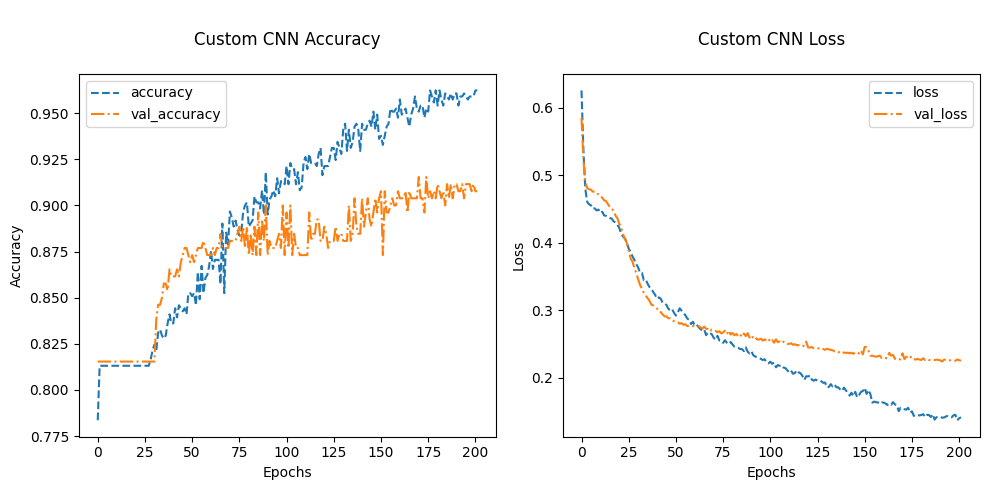

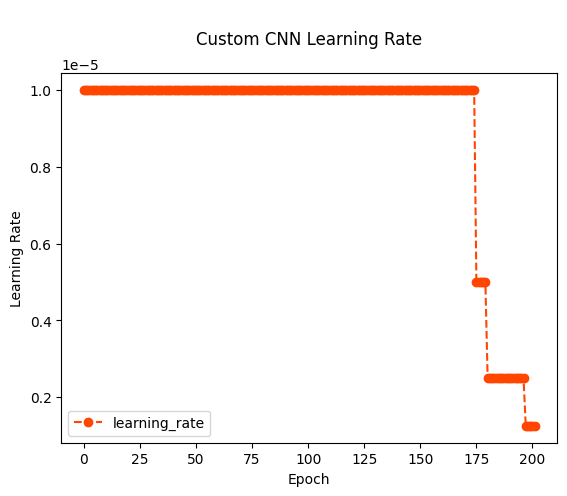

time: 815 ms (started: 2024-07-09 16:48:15 +00:00)


In [33]:
try:
    History(cnn_history, model_name='Custom CNN').plot_accuracy_and_lost()
    History(cnn_history, model_name='Custom CNN').plot_learningrate()
except AttributeError:
    print("\nKesalahan: History training tidak ada!\n")

## 7.2. VGG-19

In [34]:
CALLBACKS = callbacks_list(
    monitor=Config.MONITOR,
    model_save_pathname='vgg19_best_model.keras',
    early_stopping_patience=Config.ES_PATIENCE,
    learning_rate_patience=Config.LR_PATIENCE,
    learning_rate_scheme=Config.LR_SCHEME
)

vgg19_history = train_model_with_callbacks(
    model=vgg19_model,
    training_set=train_set,
    validation_set=valid_set,
    epochs=Config.EPOCH,
    batch_size=Config.BATCH_SIZE,
    verbose='auto',
    callbacks=CALLBACKS,
)

		START TRAINING

Epoch 1/1000


2024-07-09 16:48:48.514716: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-09 16:48:49.348185: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.97774, expected 2.11937
2024-07-09 16:48:49.348239: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.05083, expected 3.19246
2024-07-09 16:48:49.348253: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.52967, expected 3.6713
2024-07-09 16:48:49.348266: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Di

 5/10 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3625 - loss: 0.7577

2024-07-09 16:50:25.592222: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.1816, expected 2.29509
2024-07-09 16:50:25.592287: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.86329, expected 3.97678
2024-07-09 16:50:25.592302: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.07588, expected 4.18936
2024-07-09 16:50:25.592319: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.94519, expected 5.05868
2024-07-09 16:50:25.592333: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.31829, expected 5.43178
2024-07-09 16:50:25.592344: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.64006, expected 5.75355
2024-07-09 16:50:25.592355: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.81686, expected 5.93035
2024-07-09 16:50:25.592372: E external/local_xla/xla/ser

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4931 - loss: 0.6912

W0000 00:00:1720543882.453631     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-07-09 16:51:27.859001: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.24577, expected 2.80959
2024-07-09 16:51:27.859061: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 179: 3.17396, expected 2.73778
2024-07-09 16:51:27.859526: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.15611, expected 2.41005
2024-07-09 16:51:27.859568: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 3.84262, expected 3.09657
2024-07-09 16:51:27.859585: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.59187, expected 3.84581
2024-07-09 16:51:27.859597: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65539: 5.43123, expected 4.68518
2024-07-09 16:51:27.859608: E external/local_xl


Epoch 1: val_loss improved from inf to 813.17053, saving model to vgg19_best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 192s 8s/step - accuracy: 0.5092 - loss: 0.6813 - val_accuracy: 0.8077 - val_loss: 813.1705 - learning_rate: 1.0000e-05
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8035 - loss: 0.4534
Epoch 2: val_loss did not improve from 813.17053
10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8043 - loss: 0.4506 - val_accuracy: 0.8077 - val_loss: 1006.4888 - learning_rate: 1.0000e-05
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8057 - loss: 0.3848
Epoch 3: val_loss improved from 813.17053 to 742.88940, saving model to vgg19_best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8031 - loss: 0.3899 - val_accuracy: 0.8115 - val_loss: 742.8894 - learning_rate: 1.0000e-05
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8119 - loss: 0.3264
Epoch 4: val_loss did not improve from 742.88940
10/10 ━━━━━━━━━━━━━━━━━━━

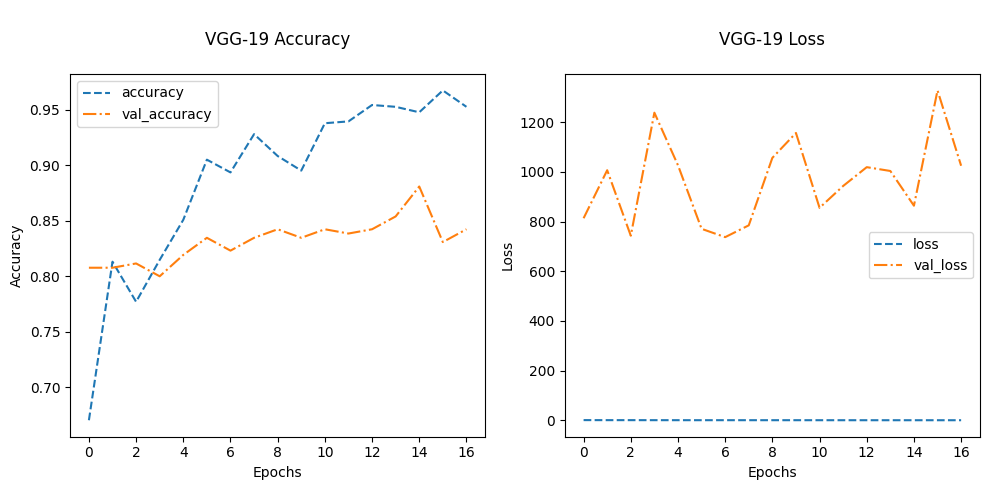

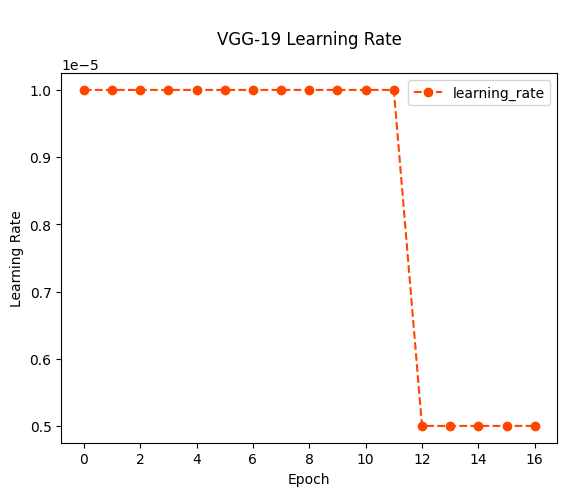

time: 812 ms (started: 2024-07-09 17:01:23 +00:00)


In [35]:
try:
    History(vgg19_history, model_name='VGG-19').plot_accuracy_and_lost()
    History(vgg19_history, model_name='VGG-19').plot_learningrate()
except AttributeError:
    print("\nKesalahan: History training tidak ada!\n")

## 7.3. EfficientNetV2B2

In [36]:
CALLBACKS = callbacks_list(
    monitor=Config.MONITOR,
    model_save_pathname='efficientnetv2b2_best_model.keras',
    early_stopping_patience=Config.ES_PATIENCE,
    learning_rate_patience=Config.LR_PATIENCE,
    learning_rate_scheme=Config.LR_SCHEME
)

efficientnetv2b2_history = train_model_with_callbacks(
    model=efficientnetv2b2_model,
    training_set=train_set,
    validation_set=valid_set,
    epochs=Config.EPOCH,
    batch_size=Config.BATCH_SIZE,
    verbose='auto',
    callbacks=CALLBACKS,
)

		START TRAINING

Epoch 1/1000
 1/10 ━━━━━━━━━━━━━━━━━━━━ 25:33 170s/step - accuracy: 0.5781 - loss: 0.6640

W0000 00:00:1720544660.185144     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6661 - loss: 0.6442 

W0000 00:00:1720544764.790775     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.74257, saving model to efficientnetv2b2_best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 286s 13s/step - accuracy: 0.6711 - loss: 0.6424 - val_accuracy: 0.1846 - val_loss: 0.7426 - learning_rate: 1.0000e-05
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.7860 - loss: 0.5834
Epoch 2: val_loss did not improve from 0.74257
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7876 - loss: 0.5824 - val_accuracy: 0.1846 - val_loss: 0.8003 - learning_rate: 1.0000e-05
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.8638 - loss: 0.5253
Epoch 3: val_loss did not improve from 0.74257
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8630 - loss: 0.5248 - val_accuracy: 0.1846 - val_loss: 0.9118 - learning_rate: 1.0000e-05
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.8645 - loss: 0.4873
Epoch 4: val_loss did not improve from 0.74257
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8640 - loss:

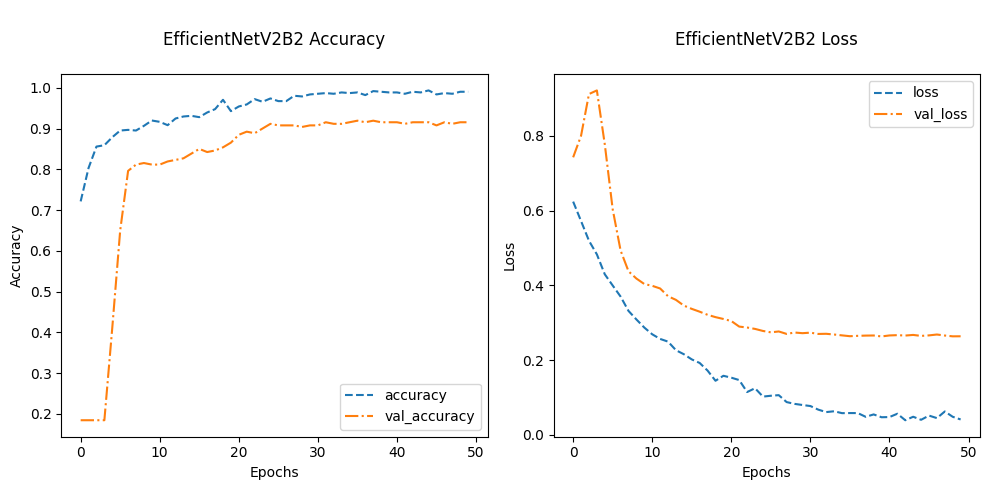

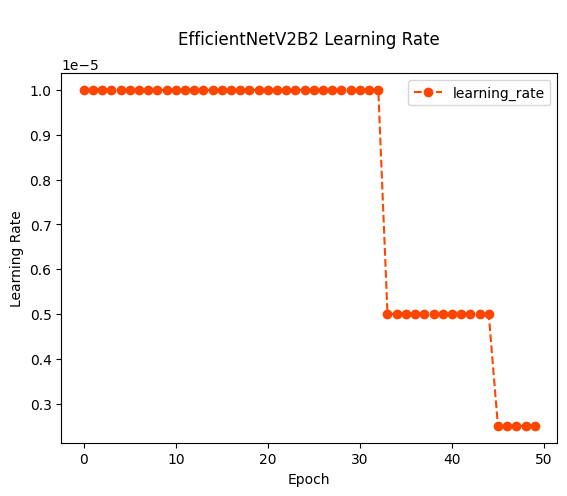

time: 876 ms (started: 2024-07-09 17:36:37 +00:00)


In [37]:
try:
    History(efficientnetv2b2_history, model_name='EfficientNetV2B2').plot_accuracy_and_lost()
    History(efficientnetv2b2_history, model_name='EfficientNetV2B2').plot_learningrate()
except AttributeError:
    print("\nKesalahan: History training tidak ada!\n")

# 8. Evaluate

## 8.1. Custom CNN

1/4 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step

W0000 00:00:1720547003.050496     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step
Custom CNN Classification Report
              precision    recall  f1-score   support

        Asli       0.91      0.43      0.58       165
       Palsu       0.33      0.87      0.48        53

    accuracy                           0.54       218
   macro avg       0.62      0.65      0.53       218
weighted avg       0.77      0.54      0.56       218



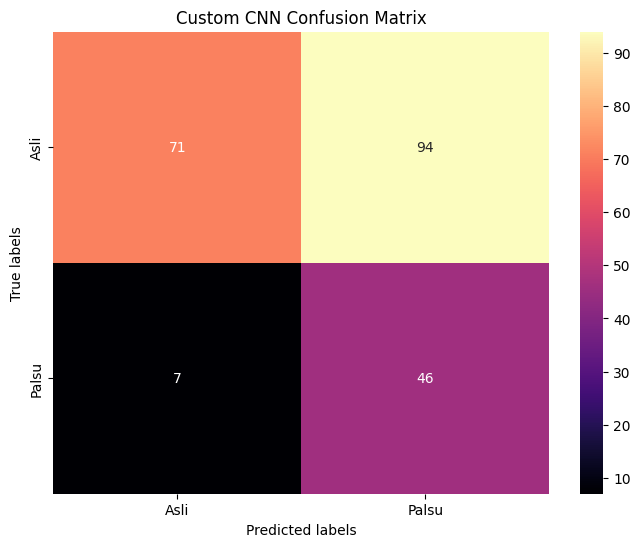

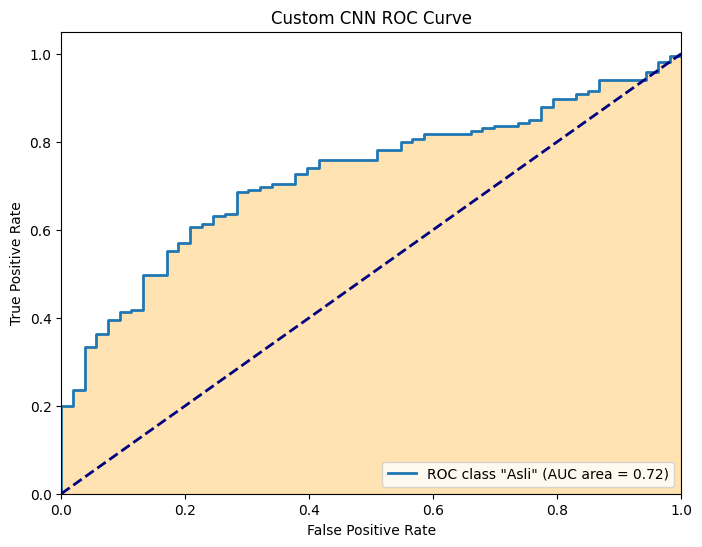

time: 37.8 s (started: 2024-07-09 17:43:01 +00:00)


In [43]:
try:
    cnn_best_model = load_model('cnn_best_model.keras')
    cnn_evaluator = ModelEvaluation(cnn_best_model, test_set, model_name='Custom CNN')

    cnn_y_true, cnn_y_pred = cnn_evaluator.predict_test()
    
    cnn_evaluator.classification_report()
    cnn_evaluator.plot_confusion_matrix()
    cnn_evaluator.plot_roc_auc()
except OSError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')
except ValueError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')

## 8.2. VGG-19

1/4 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step

W0000 00:00:1720547044.042868     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step
VGG-19 Classification Report
              precision    recall  f1-score   support

        Asli       0.76      1.00      0.86       165
       Palsu       0.00      0.00      0.00        53

    accuracy                           0.76       218
   macro avg       0.38      0.50      0.43       218
weighted avg       0.57      0.76      0.65       218



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


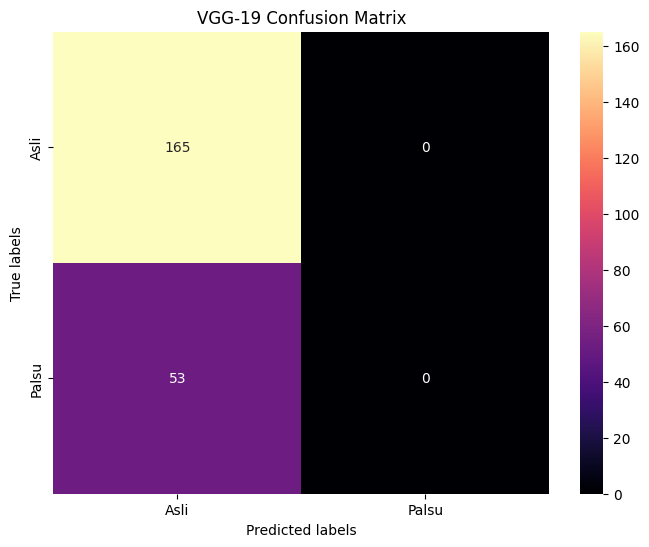

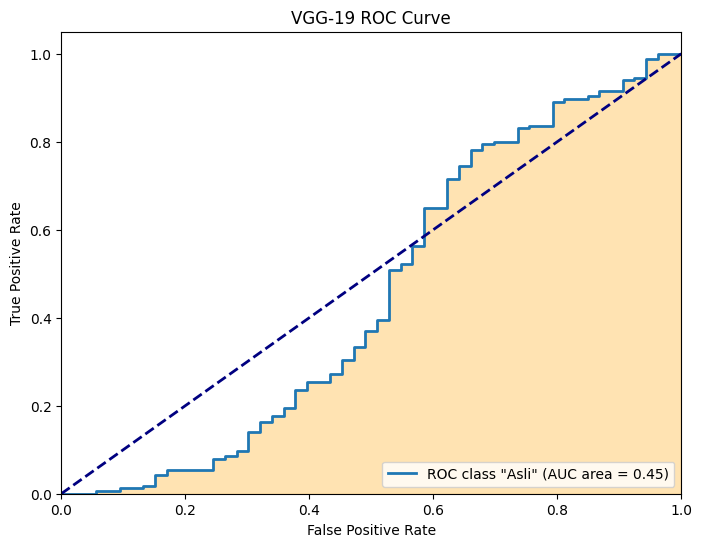

time: 41.3 s (started: 2024-07-09 17:43:39 +00:00)


In [44]:
try:
    vgg19_best_model = load_model('vgg19_best_model.keras')
    vgg19_evaluator = ModelEvaluation(vgg19_best_model, test_set, model_name='VGG-19')

    vgg19_y_true, vgg19_y_pred = vgg19_evaluator.predict_test()
    
    vgg19_evaluator.classification_report()
    vgg19_evaluator.plot_confusion_matrix()
    vgg19_evaluator.plot_roc_auc()
except OSError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')
except ValueError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')

## 8.3. EfficientNetV2B2

2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

W0000 00:00:1720547101.808188     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step
EfficientNetV2B2 Classification Report
              precision    recall  f1-score   support

        Asli       0.93      0.90      0.91       165
       Palsu       0.71      0.79      0.75        53

    accuracy                           0.87       218
   macro avg       0.82      0.84      0.83       218
weighted avg       0.88      0.87      0.87       218



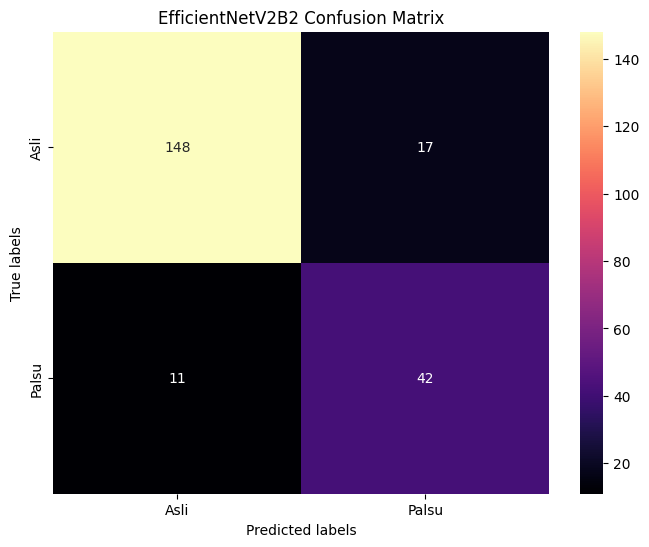

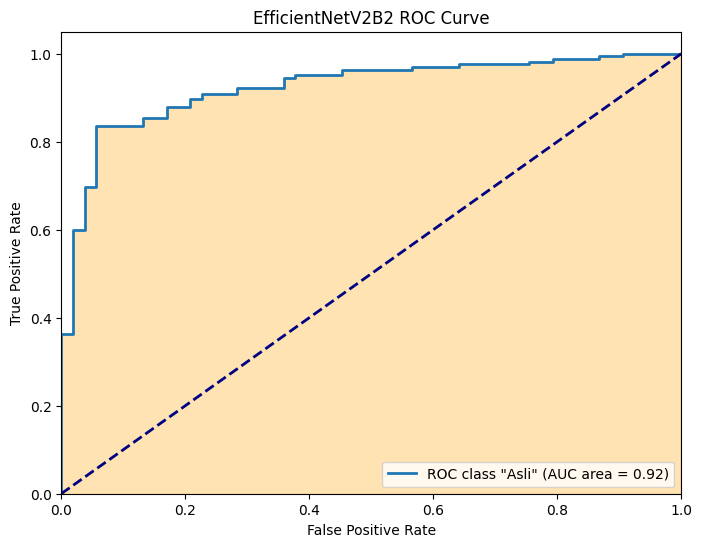

time: 1min (started: 2024-07-09 17:44:20 +00:00)


In [45]:
try:
    efficientnetv2b2_best_model = load_model('efficientnetv2b2_best_model.keras')
    efficientnetv2b2_evaluator = ModelEvaluation(efficientnetv2b2_best_model, test_set, model_name='EfficientNetV2B2')

    efficientnetv2b2_y_true, efficientnetv2b2_y_pred = efficientnetv2b2_evaluator.predict_test()
    
    efficientnetv2b2_evaluator.classification_report()
    efficientnetv2b2_evaluator.plot_confusion_matrix()
    efficientnetv2b2_evaluator.plot_roc_auc()
except OSError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')
except ValueError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')